---
## Classification - MNIST dataset
---

Exploring the popular MNIST dataset. 

Tensorflow provides a function to ingest the data.

In [1]:
# Necessary imports
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
from matplotlib.pyplot import imshow
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

# Read the mnist dataset
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Python variables for the image np arrays and labels
X_train = mnist.train.images
Y_train = mnist.train.labels
X_test = mnist.test.images
Y_test = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Lets look at a random image and its label

Image label: 8


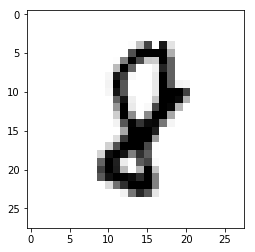

In [2]:
# Pull out a random image & its label
random_image_index = 200
random_image = X_train[random_image_index]
random_image_label = Y_train[random_image_index]

# Print the label and the image as grayscale
print("Image label: %d"%(random_image_label.argmax()))
pil_image = Image.fromarray(((random_image.reshape(28,28)) * 256).astype('uint8'), "L")
imshow(ImageOps.invert(pil_image), cmap='gray')

---
## Nearest Neighbor Classifier
---

Build a nearest neighbors classifier using a **subset** of mnist data.

In [3]:
# Read only a subsample
Xtr, Ytr = mnist.train.next_batch(5000)
Xte, Yte = mnist.test.next_batch(200)

* **Step 1**: Create placeholders to hold the images. 

  Using `None` for a dimension in shape means it can be *any* number.

In [4]:
# Create placeholders
xtr = tf.placeholder(tf.float32, shape=(None, 784))
xte = tf.placeholder(tf.float32, shape=[784])

* **Step 2**: Lets build a graph using the following operations

  1. First get the deltas along each dimension (pixel value): Use `tf.substract` to subtract **xtr** (train) with **xte** (test).  
  (*Note that **xtr** has 784 columns (28x28) and can have any number of rows (examples). **xte** however is a vector of only 784 elements. `tf.substract` is a **broadcast** operation where each row of `xtr` is subtracted by xte.*)
      
  2. Next, get the squared deltas for each dimension: Use `tf.square` which performs elementwise squaring.
  
  3. Now compute the L2 distance. First use `tf.reduce_sum` to sum up all the `784` columns with squared deltas. Then use `tf.srqt` to compute the square root to get the L2 distance. Note that *distance* is a vector comprising distance of a particular test image with each of the train image.
  
  4. Find out the nearest neighbor. Use `tf.arg_min` (similar to numpy) to get the index of the closest training example.

In [5]:
# Image deltas
deltas = tf.subtract(xtr, xte)
squared_deltas = tf.square(deltas)

# L2 distance:  Root of the sum of squared deltas
distance = tf.sqrt(tf.reduce_sum(squared_deltas, axis=1))

# This is the nearest neighbor
nearest_neighbor = tf.arg_min(distance, 0)

Now lets create a session and run the graph over the entire test set

In [6]:
# A variable to keep track of the accuracy
accuracy = 0

# Initializing global variables
init = tf.global_variables_initializer()

# Create a session to run the graph
with tf.Session() as sess:
    # Run initialization
    sess.run(init)
    
    # Loop over all the test data
    for i in range(len(Xte)):

        # Get the nearest neighbor, i.e the row number/example number from the training dataset
        nearest_neighbor_index = sess.run(nearest_neighbor, feed_dict={xtr: Xtr, xte: Xte[i,:]})

        # Extract the predicted label
        predicted_label = np.argmax(Ytr[nearest_neighbor_index,:])

        # Get the actual label and compare it 
        #print("Example: %d\t"%i, "Predicted: %d\t"%predicted_label, "Actual: %d"%np.argmax(Yte[i]))
        
        # Calculate accuracy
        if predicted_label == np.argmax(Yte[i]):
            accuracy += 1
    
    print("Classification done. Accuracy: %f"%(accuracy/len(Xte)))

Classification done. Accuracy: 0.920000


Now we can extend this to more than just one nearest neighbor and feed "k" in at runtime. 

In [7]:
# Lets create a placeholder for k
k = tf.placeholder(tf.int32)

# Distances computation doesn't change.

# Create a new variable that holds a vector of nearest neighbors
# Use the top k function but flip the distance scores with a engative sign
# K is fed in
# The top k returns both values and indicies as a tuple. Using [1] only gives us the indicies
nearest_neighbors = tf.nn.top_k(tf.negative(distance), k=k)[1]

# Rest of the code remains mostly the same.
# Create the session as usual, initialize and run the the graph
# Note that now k has to be "fed" into the graph
accuracy = 0

# Initializing global variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Run initialization
    sess.run(init)
    
    # Loop over all the test data
    for i in range(len(Xte)):
        # Get the nearest neighbor, i.e the row number/example number from the training dataset
        nearest_neighbor_indices = sess.run(nearest_neighbors, feed_dict={xtr: Xtr, xte: Xte[i,:], k:5})
        
        # Extract the predicted labels by summing the different predictions and picking the one with highest votes
        # Note that in case of equal votes, ideally the label of the nearest neighbor must be picked.
        # For the demonstration purposes, it is ignored & argmax picks the first highest element
        predicted_label = np.argmax(np.sum(Ytr[nearest_neighbor_indices,:], 0))
        
        # Get the actual label and compare it 
        #print("Example: %d\t"%i, "Predicted: %d\t"%predicted_label, "Actual: %d"%np.argmax(Yte[i]))
        
        # Calculate accuracy
        if predicted_label == np.argmax(Yte[i]):
            accuracy += 1 
    print("Classification done. Accuracy: %f"%(accuracy/len(Xte)))

Classification done. Accuracy: 0.935000
